# Binary Classification: Movie Reviews
Utilize the IMDB data set in Keras: 50,000 polarized reviews split in half, one set for training, the other for testing. The data is made up of 50% negative reviews and 50% positive reviews.

The data is preprocessed: each review (a sequence of words) has beed translated into a sequence of integers such that each integer stands for a particular word in a dictionary.

Code based on example by Francois Chollet in *Deep Learning with Python, Second Edition*.

In [1]:
# Load the dataset (about 80MB).
# Retain only 10,000 of most frequently occuring words. 
from tensorflow.keras.datasets import imdb
(trainData, trainLabels), (testData, testLabels) = imdb.load_data(num_words=10_000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

`trainData` and `testData` are lists of reviews: each review is a list of word indices. 

`trainLabels` and `testLabels` are lists of 0s and 1s such that 0 implies *negative* and 1 implies *positive*.

In [2]:
# See that word index does not exceed 10,000:
max([max(sequence) for sequence in trainData])

9999

See what one review (e.g., `trainData[9]`) looks like decoded.

In [11]:
wordIndex = imdb.get_word_index() # Dict mapping words to integer index.
reverseWordIndex = dict(
    # Map integer indices to words.
    [(value, key) for (key, value) in wordIndex.items()]
)
decodedReview = " ".join(
    # Indices offset by 3 since 0, 1, and 2 are 
    #  "padding", "start of sequence", and "unknown", respectively.
    [reverseWordIndex.get(i-3, "?") for i in trainData[9]]
)

# Show decoded review
decodedReview

"? this movie has many problem associated with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its ? though many times throughout the movie i found myself laughing hysterically it was so bad at times that it was comical which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a dash of campy ? then pop a bowl of popcorn invite some friends over and have some fun br br i agree with other comments that the sound is very bad dialog is next to impossible to follow much of the time and the soundtrack is kind of just there"

### Prepare the data
Neural network won't accept lists of integers (reviews). The lengths of the lists vary and the network expects adjoining data. Need to turn lists into tensors. 

We use one-hot encoding on the lists to get vectors with values of 0s and 1s. Thus, transforming the sequence `[1, 5, 3]` into a 10,000 dimensional vector will produce a vector that is all 0s except for indices 1, 5, and 3. 

In [4]:
import numpy as np
def vectorize_sequences(sequences, dimension=10_000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Set specific indices of results[i] to 1.
    return results
# Vectorize training data.
xTrain = vectorize_sequences(trainData) 
xTest = vectorize_sequences(testData)

In [5]:
# Also vectorize labels:
yTrain = np.asarray(trainLabels).astype('float32')
yTest = np.asarray(testLabels).astype('float32')

In [16]:
# See training data is one-hot encoded.
xTrain[9]

array([0., 1., 1., ..., 0., 0., 0.])

## Feed data into neural network
Simple setup: input is vectors, labels are binary scalars. A good model for binary classification problems is a plain stack of densesly-connected (`Dense`) layers with `relu` activations.

`relu` (rectified linear unit) is a function for zeroing out negative values, whereas a `sigmoid` squishes values into the $[0, 1]$ interval. 

Furthermore, `relu` introduces *non-linearity* into our model so we can get beyond the model used in our LinearClassification problem which only used affine (linear) transformations. Using non-linearity, we extend the *hypothesis space* of a layer which allows us to benefit from multiple layers or representations, since adding more layers to linear layers would still be a linear operation.

In [17]:
# Define model:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Output is a probability.
])

Each `Dense` layer with `relu` activation implements chain of tensor operations:

    output = relu(dot(W, input) + b)


Need to choose loss function and optimizer. A binary classification model is a probability in the end (single-unit layer with `sigmoid` activation), so we use `binary_crossentropy` loss, often used for models that output probabilities. 

Optimizer is `rmsprop`, a good default choice.

In [18]:
# Compile the model.
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Create validation set by setting aside 10,000 samples from the original 
#  training data.
xVal = xTrain[:10000]
xPartialTrain = xTrain[10000:]
yVal = yTrain[:10000]
yPartialTrain = yTrain[10000:]

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(xPartialTrain,
                    yPartialTrain,
                    epochs=20,
                    batch_size=512, # Mini-batches of 512 samples
                    validation_data=(xVal, yVal))

Epoch 1/20
30/30 [==============================] - 4s 33ms/step - loss: 0.5890 - acc: 0.7089 - val_loss: 0.3907 - val_acc: 0.8580
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3211 - acc: 0.8972 - val_loss: 0.2994 - val_acc: 0.8880
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2236 - acc: 0.9291 - val_loss: 0.2895 - val_acc: 0.8841
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1709 - acc: 0.9465 - val_loss: 0.2751 - val_acc: 0.8882
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1312 - acc: 0.9634 - val_loss: 0.2831 - val_acc: 0.8871
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1114 - acc: 0.9682 - val_loss: 0.3001 - val_acc: 0.8827
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0940 - acc: 0.9727 - val_loss: 0.3236 - val_acc: 0.8811
Epoch 8/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0730 - a

In [21]:
# model.fit() returns History object, a dictionary with data
#  on what happened during training
historyDict = history.history
historyDict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

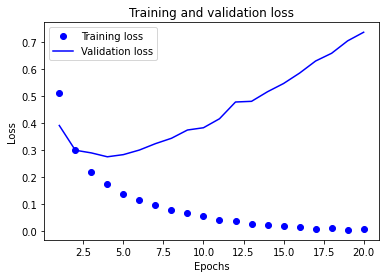

In [23]:
import matplotlib.pyplot as plt
# Plot training and validation loss.
lossValues = historyDict['loss']
val_lossValues = historyDict['val_loss']
epochs = range(1, len(lossValues)+1)
plt.plot(epochs, lossValues, 'bo', label='Training loss') # blue dot
plt.plot(epochs, val_lossValues, 'b', label="Validation loss") # blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

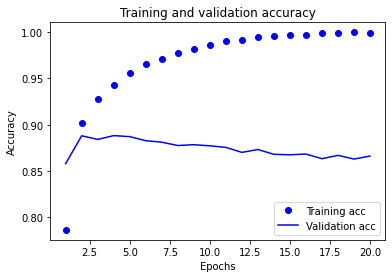

In [24]:
# Plot training and validation accuracy.
plt.clf() # Clear figures
acc = historyDict['acc']
val_acc = historyDict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Since `val_loss` and `val_acc` seem to peak around fourth epoch, we are *overfitting* in the fifth epoch and beyond. To correct this, we'll stop training after three epochs.

In [25]:
# Train new model for four epochs.
model = keras.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=4, batch_size=512)
results = model.evaluate(xTest, yTest)

Epoch 1/4
49/49 [==============================] - 1s 12ms/step - loss: 0.6054 - accuracy: 0.6277
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.3035 - accuracy: 0.9028
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2093 - accuracy: 0.9298
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.3203 - accuracy: 0.8754


In [49]:

print("Achieved accuracy of %d precent with a loss of %.2f." % (round(results[1]*100), results[0]))

Achieved accuracy of 88 precent with a loss of 0.32.
